# Library

In [42]:
# Python Library
import os, glob, sys
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings("ignore")

# Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
#
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

In [43]:
from astropy.visualization import ZScaleInterval, LinearStretch, LogStretch
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from matplotlib.colors import LogNorm  # LogNorm 추가
from matplotlib.patches import Circle

In [44]:
from astropy.stats import sigma_clipped_stats

In [57]:
def calc_weighted_median_zp(zp_arr, zperr_arr):
	weights = [1 / error for error in zperr_arr]

	weighted_sum = sum(value * weight for value, weight in zip(zp_arr, weights))
	total_weight = sum(weights)
	zp = weighted_sum / total_weight

	total_weight = sum(weights)
	weighted_diff_sum = sum(((value - zp) ** 2) * weight for value, weight in zip(zp_arr, weights))
	zperr = (weighted_diff_sum / (total_weight - 1)) ** 0.5

	print(f"zp = {zp:.3f}+/-{zperr:.3f}")
	return zp, zperr

In [76]:
def check_slope(x, y, yerr, plot=False, verbose=False):
	from sklearn.linear_model import LinearRegression

	model = LinearRegression()
	# x = mtbl[f'{filte}mag'].reshape(-1, 1)
	# y = zp_ps1_arr.reshape(-1, 1)
	x = x.reshape(-1, 1)
	y = y.reshape(-1, 1)
	model.fit(x, y, sample_weight=1 / yerr**2)

	# 회귀 결과 추출
	slope = model.coef_[0][0]  # 기울기
	intercept = model.intercept_[0]  # y 절편

	if plot:
		# 회귀선 그리기
		plt.scatter(x, y, label='Data', alpha=0.5)
		plt.plot(x, model.predict(x), color='red', label=f'Linear Regression (a={slope:.3f}, b={intercept:.3f})')
		plt.xlabel(r"$\rm m_{PS1}$")
		plt.ylabel('ZP')
		plt.ylim([intercept+2, intercept-2])
		plt.title('Weighted Linear Regression')
		plt.legend()

		plt.show()

	if verbose:
		# 회귀 결과 출력
		print(f"Slope (기울기): {slope}")
		print(f"Intercept (y 절편): {intercept}")
	return (slope, intercept)

# Input

## Source EXtractor

In [45]:
#	Source EXtractor
imlist = sorted(glob.glob('../data/spss/LTT1020/C*m.fits'))
for _inim in imlist:
	inim = os.path.basename(_inim)
	outcat = inim.replace('.fits', '.cat')
	sexcom = f"sex -c simple.sex -CATALOG_NAME {outcat} {inim}"
	print(sexcom)

sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-060223-u-360.com.cat Calib-7DT01-LTT1020-20231011-060223-u-360.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-060857-g-70.com.cat Calib-7DT01-LTT1020-20231011-060857-g-70.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-061211-r-70.com.cat Calib-7DT01-LTT1020-20231011-061211-r-70.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-061640-i-210.com.cat Calib-7DT01-LTT1020-20231011-061640-i-210.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-062417-z-420.com.cat Calib-7DT01-LTT1020-20231011-062417-z-420.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-063158-m400-210.com.cat Calib-7DT01-LTT1020-20231011-063158-m400-210.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-063807-m425-210.com.cat Calib-7DT01-LTT1020-20231011-063807-m425-210.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-

## Read Tables

In [46]:
catlist = sorted(glob.glob('../data/spss/LTT1020/C*cat'))
print(f"{len(catlist)} catalogs found")

9 catalogs found


- PS1

In [47]:
ps1tbl = Table.read('../data/spss/LTT1020/ps1-LTT1020.cat', format='ascii')
c_ps1 = SkyCoord(ra=ps1tbl['RA_ICRS'], dec=ps1tbl['DE_ICRS'], frame='icrs')

- Gaia

In [119]:
# gtbl = Table.read('../output/gaia-LTT1020.cat', format='csv')
gtbl = Table.read('../output/LTT1020.pre.csv', format='csv')
c_gaia = SkyCoord(ra=gtbl['ra'], dec=gtbl['dec'], unit='deg', frame='icrs')

# Analysis

In [49]:
nn = 1
incat = catlist[nn]

inim = imlist[nn]
#	Image
filte = inim.split('-')[-2]
data = fits.getdata(inim)
bkg = np.median(data)
print(f"{os.path.basename(inim)} (bkg={bkg:.3f})")
print(os.path.basename(incat))

#	Table
intbl = Table.read(incat, format='ascii.sextractor')
intbl['SNR'] = intbl['FLUX_AUTO']/intbl['FLUXERR_AUTO']
c_7dt = SkyCoord(ra=intbl['ALPHA_J2000'], dec=intbl['DELTA_J2000'])

Calib-7DT01-LTT1020-20231011-060857-g-70.com.fits (bkg=10.128)
Calib-7DT01-LTT1020-20231011-060857-g-70.com.cat


## Matching with PS1

In [79]:
indx_match, sep, _ = c_7dt.match_to_catalog_sky(c_ps1)
_mtbl = hstack([intbl, ps1tbl[indx_match]])
print(f"Matched {len(_mtbl)} sources")

Matched 4128 sources


In [83]:
_zp_ps1_arr = _mtbl[f'{filte}mag']-_mtbl['MAG_AUTO']
_zperr_ps1_arr = np.sqrt( (_mtbl[f'e_{filte}mag']**2) + (_mtbl['MAGERR_AUTO']**2) )

In [84]:
mtbl = _mtbl[
	(sep.arcsec<2) &
	(~_mtbl[f'{filte}mag'].mask) &
	(_mtbl[f'{filte}mag']>14) &
	(_mtbl[f'{filte}mag']<18) &
	(_mtbl['SNR']>50)
	]
print(f"Selected {len(mtbl)} sources")

Selected 294 sources


In [85]:
zp_ps1_arr = mtbl[f'{filte}mag']-mtbl['MAG_AUTO']
zperr_ps1_arr = np.sqrt( (mtbl[f'e_{filte}mag']**2) + (mtbl['MAGERR_AUTO']**2) )

- 3.0 Sigma Clipping
Alive: 290
Exile: 4
zp = 26.433+/-0.032


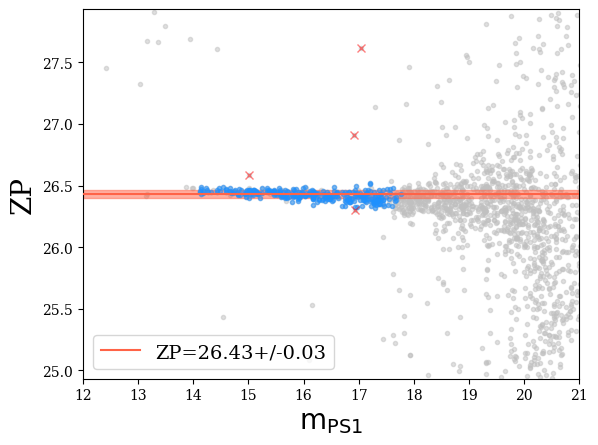

In [96]:
from astropy.stats import sigma_clip

sigma = 3.0
maxiters = None

#	SIGMA CLIPPING
zp_ps1_clip_arr = sigma_clip(
	zp_ps1_arr.copy(),
	sigma=sigma,
	maxiters=maxiters,
	cenfunc=np.median,
	copy=False
	)
indx_alive = np.where( zp_ps1_clip_arr.mask == False )
indx_exile = np.where( zp_ps1_clip_arr.mask == True )

print(f"- {sigma} Sigma Clipping")
print(f"Alive: {len(zp_ps1_arr[indx_alive])}")
print(f"Exile: {len(zp_ps1_arr[indx_exile])}")

zp_ps1, zperr_ps1 = calc_weighted_median_zp(zp_ps1_arr[indx_alive], zperr_ps1_arr[indx_alive])


plt.plot(_mtbl[f'{filte}mag'], _zp_ps1_arr, '.', c='silver', alpha=0.5, zorder=0)
# plt.plot(mtbl[f'{filte}mag'], zp_ps1_arr, '.', alpha=0.5)
plt.plot(mtbl[f'{filte}mag'][indx_alive], zp_ps1_arr[indx_alive], '.', color='dodgerblue', alpha=0.5)
plt.plot(mtbl[f'{filte}mag'][indx_exile], zp_ps1_arr[indx_exile], 'xr', alpha=0.5)

plt.axhline(y=zp_ps1, ls='-', color='tomato', zorder=999, label=f'ZP={zp_ps1:.2f}+/-{zperr_ps1:.2f}')
plt.axhspan(ymin=zp_ps1-zperr_ps1, ymax=zp_ps1+zperr_ps1, color='tomato', zorder=0, alpha=0.5)
plt.xlabel(r"$\rm m_{PS1}$")
plt.ylabel("ZP")
plt.xlim([12, 21])
plt.ylim(zp_ps1-1.5, zp_ps1+1.5)
plt.legend(fontsize=14)

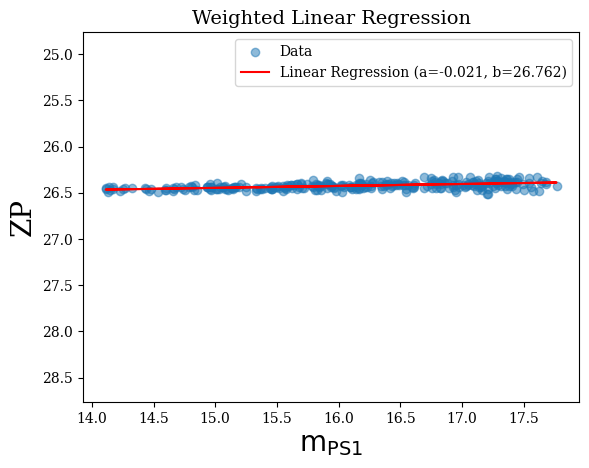

Slope (기울기): -0.02096804413519488
Intercept (y 절편): 26.762006520680526


(-0.02096804413519488, 26.762006520680526)

In [78]:
check_slope(mtbl[f'{filte}mag'][indx_alive], zp_ps1_arr[indx_alive], zperr_ps1_arr[indx_alive], plot=True, verbose=True)

## Matching with Gaia

In [125]:
indx_match, sep, _ = c_7dt.match_to_catalog_sky(c_gaia)
_mtbl = hstack([intbl, gtbl[indx_match]])
print(f"Matched {len(_mtbl)} sources")

Matched 4128 sources


In [126]:
_zp_gaia_arr = _mtbl[f'skymapper_mag_{filte}']-_mtbl['MAG_AUTO']
_zperr_gaia_arr = np.zeros_like(_zp_gaia_arr)

In [129]:
mtbl = _mtbl[
	(sep.arcsec<2) &
	# (~_mtbl[f'skymapper_mag_{filte}'].mask) &
	(_mtbl[f'skymapper_mag_{filte}']>14) &
	(_mtbl[f'skymapper_mag_{filte}']<18) &
	(_mtbl['SNR']>50)
	]
print(f"Selected {len(mtbl)} sources")

Selected 205 sources


In [133]:
zp_gaia_arr = mtbl[f'skymapper_mag_{filte}']-mtbl['MAG_AUTO']
zperr_gaia_arr = np.zeros_like(zp_gaia_arr)

- 3.0 Sigma Clipping
Alive: 204
Exile: 1


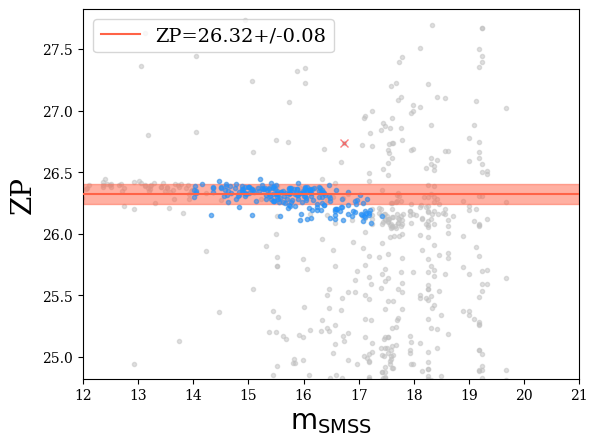

In [138]:
from astropy.stats import sigma_clip

sigma = 3.0
maxiters = None

#	SIGMA CLIPPING
zp_gaia_clip_arr = sigma_clip(
	zp_gaia_arr.copy(),
	sigma=sigma,
	maxiters=maxiters,
	cenfunc=np.median,
	copy=False
	)
indx_alive = np.where( zp_gaia_clip_arr.mask == False )
indx_exile = np.where( zp_gaia_clip_arr.mask == True )

print(f"- {sigma} Sigma Clipping")
print(f"Alive: {len(zp_gaia_arr[indx_alive])}")
print(f"Exile: {len(zp_gaia_arr[indx_exile])}")

zp_gaia, zperr_gaia = np.median(zp_gaia_arr[indx_alive]), np.std(zp_gaia_arr[indx_alive])


plt.plot(_mtbl[f'skymapper_mag_{filte}'], _zp_gaia_arr, '.', c='silver', alpha=0.5, zorder=0)
# plt.plot(mtbl[f'skymapper_mag_{filte}'], zp_gaia_arr, '.', alpha=0.5)
plt.plot(mtbl[f'skymapper_mag_{filte}'][indx_alive], zp_gaia_arr[indx_alive], '.', color='dodgerblue', alpha=0.5)
plt.plot(mtbl[f'skymapper_mag_{filte}'][indx_exile], zp_gaia_arr[indx_exile], 'xr', alpha=0.5)

plt.axhline(y=zp_gaia, ls='-', color='tomato', zorder=999, label=f'ZP={zp_gaia:.2f}+/-{zperr_gaia:.2f}')
plt.axhspan(ymin=zp_gaia-zperr_gaia, ymax=zp_gaia+zperr_gaia, color='tomato', zorder=0, alpha=0.5)
plt.xlabel(r"$\rm m_{SMSS}$")
plt.ylabel("ZP")
plt.xlim([12, 21])
plt.ylim(zp_gaia-1.5, zp_gaia+1.5)
plt.legend(fontsize=14)